<a href="https://colab.research.google.com/github/phantommarheaven7621/COVID19_Face_Mask_Detection/blob/main/COVID19_Face_Mask_Detection_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download prithwirajmitra/covid-face-mask-detection-dataset

In [ ]:
! unzip covid-face-mask-detection-dataset.zip

# **Directories**

In [95]:
# Paths of directories

import os

base_dir = '/content/New Masks Dataset'

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

# Mask and None Mask for train_dir
train_mask_dir = os.path.join(train_dir, 'Mask')
train_nonmask_dir = os.path.join(train_dir, 'Non Mask')

# Mask and None Mask for val_dir
val_mask_dir = os.path.join(val_dir, 'Mask')
val_nonmask_dir = os.path.join(val_dir, 'Non Mask')

# Mask and None Mask for test_dir
test_mask_dir = os.path.join(test_dir, 'Mask')
test_nonmask_dir = os.path.join(test_dir, 'Non Mask')

In [96]:
# List of file names

train_mask_fnames = os.listdir(train_mask_dir)
train_nonmask_fnames = os.listdir(train_nonmask_dir)
val_mask_fnames = os.listdir(val_mask_dir)
val_nonmask_fnames = os.listdir(val_nonmask_dir)
test_mask_fnames = os.listdir(test_mask_dir)
test_nonmask_fnames = os.listdir(test_nonmask_dir)

print('Training mask: {} images'.format(len(train_mask_fnames)))
print('Training non mask: {} images\n'.format(len(train_mask_fnames)))
print('Validation mask: {} images'.format(len(val_mask_fnames)))
print('Validation non mask: {} images\n'.format(len(val_mask_fnames)))
print('Testing mask: {} images'.format(len(test_mask_fnames)))
print('Testing non mask: {} images\n'.format(len(test_mask_fnames)))

Training mask: 300 images
Training non mask: 300 images

Validation mask: 153 images
Validation non mask: 153 images

Testing mask: 50 images
Testing non mask: 50 images



# Transfer Learning using MobileNetV2

In [101]:
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,  Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV2

In [102]:
# Pre-trained model

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable = False

In [103]:
# define a model

inputs = base_model.input
x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

In [104]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [105]:
# compile model
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(),
    metrics=['accuracy']
)

# Prepare data

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    seed=11,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    seed=11,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


In [107]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'Mask': 0, 'Non Mask': 1}
{'Mask': 0, 'Non Mask': 1}


In [108]:
# test data preprocessing
import numpy as np
from sklearn.utils import shuffle
import PIL.Image as Image

test_data = []
test_labels = []

def convert_to_data(dir, fnames, data, labels, value_of_labels):
  for i, name in enumerate(fnames):
    path = os.path.join(dir, name)
    img = Image.open(path).resize((224, 224))
    img = np.array(img)/255
    data.append(img)
    labels.append(value_of_labels)
  

convert_to_data(test_mask_dir, test_mask_fnames, test_data, test_labels, 0)
convert_to_data(test_nonmask_dir, test_nonmask_fnames, test_data, test_labels, 1)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

test_data, test_labels = shuffle(test_data, test_labels, random_state=0)

print('Test data: {}'.format(len(test_data)))
print('Test labels: {}\n'.format(len(test_labels)))


Test data: 100
Test labels: 100



# Training

In [109]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=4)

callback_list = [early_stop]

In [110]:
history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=50,
    validation_data=val_generator,
    validation_steps=15,
    verbose=1,
    callbacks=callback_list
)

Epoch 1/50
30/30 [==============================] - 19s 524ms/step - loss: 0.3762 - accuracy: 0.8583 - val_loss: 0.1539 - val_accuracy: 0.9467
Epoch 2/50
30/30 [==============================] - 14s 483ms/step - loss: 0.0959 - accuracy: 0.9683 - val_loss: 0.1434 - val_accuracy: 0.9400
Epoch 3/50
30/30 [==============================] - 14s 487ms/step - loss: 0.1031 - accuracy: 0.9667 - val_loss: 0.1776 - val_accuracy: 0.9333
Epoch 4/50
30/30 [==============================] - 14s 482ms/step - loss: 0.0768 - accuracy: 0.9750 - val_loss: 0.0947 - val_accuracy: 0.9600
Epoch 5/50
30/30 [==============================] - 14s 483ms/step - loss: 0.0645 - accuracy: 0.9733 - val_loss: 0.0692 - val_accuracy: 0.9667
Epoch 6/50
30/30 [==============================] - 14s 479ms/step - loss: 0.0744 - accuracy: 0.9750 - val_loss: 0.0725 - val_accuracy: 0.9700
Epoch 7/50
30/30 [==============================] - 14s 485ms/step - loss: 0.0684 - accuracy: 0.9733 - val_loss: 0.1193 - val_accuracy: 0.9533

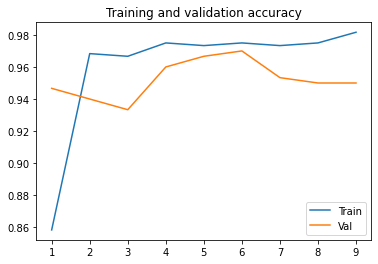

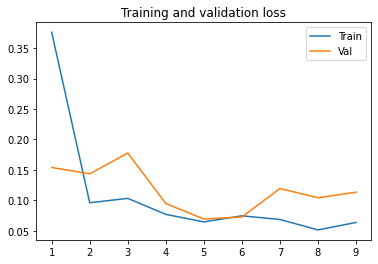

In [111]:
import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(1, len(acc)+1)

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Train')
plt.plot(epochs, val_acc, label='Val')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss, label='Val')
plt.title('Training and validation loss')
plt.legend()

In [112]:
model.evaluate(train_generator)

30/30 [==============================] - 9s 306ms/step - loss: 0.0137 - accuracy: 0.9983


[0.013664351776242256, 0.9983333349227905]

In [113]:
model.evaluate(val_generator)

16/16 [==============================] - 5s 345ms/step - loss: 0.1112 - accuracy: 0.9510


[0.11119303852319717, 0.9509803652763367]

# Prediction

In [114]:
# Prediction
test_pred = model.predict(test_data) > 0.5
test_pred = [1 if ([[i]] == [[True]]) else 0 for i in test_pred]

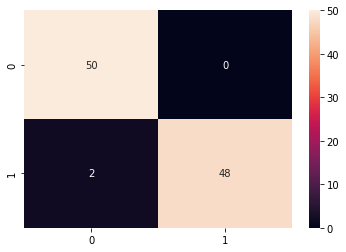

In [115]:
# Import libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_labels, test_pred)

sns.heatmap(cm, annot=True, fmt='.3g')

In [116]:
# Accuracy
model.evaluate(test_data, test_labels)

4/4 [==============================] - 1s 73ms/step - loss: 0.0666 - accuracy: 0.9800


[0.0666014701128006, 0.9800000190734863]

In [117]:
model.save('face_mask.model')

INFO:tensorflow:Assets written to: face_mask.model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [118]:
! zip -r face_mask.zip face_mask.model

updating: face_mask.model/ (stored 0%)
updating: face_mask.model/variables/ (stored 0%)
updating: face_mask.model/variables/variables.index (deflated 77%)
updating: face_mask.model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: face_mask.model/keras_metadata.pb (deflated 95%)
updating: face_mask.model/saved_model.pb (deflated 92%)
updating: face_mask.model/assets/ (stored 0%)
